# Load torch device

In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from Datasets.batching import BatchManager
from Datasets.ncars import NCars

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Model Initialization

In [2]:
from Models.CleanAEGNN.GraphRes import GraphRes as AEGNN
from torch_geometric.data import Data as PyGData

image_size: tuple[int, int] = NCars.get_info().image_size
input_shape: tuple[int, int, int] = (*image_size, 3)

model = AEGNN(
    input_shape = input_shape,
    kernel_size = 8,
    n = [1, 16, 32, 32, 32, 128, 128, 128],
    pooling_outputs = 128,
    num_outputs = len(NCars.get_info().classes),
).to(device)

def transform_graph(graph: PyGData) -> PyGData:
    graph = model.data_transform(
        graph, n_samples = 25000, sampling = True,
        beta =  0.5e-5, radius = 5.0,
        max_neighbors = 32
    ).to(device)
    return graph

# Dataset Initialization and processing (from the parsed dataset from the aegnn issues thread)

In [3]:
#Instantiating the ncaltech dataset
ncaltech = NCars(
    root=r"D:\Uniwersytet\GNNBenchmarking\Datasets\NCars\Prophesee_Dataset_n_cars",
    transform=transform_graph
)

# Processing the training part of the dataset
ncaltech.process(modes = ["training"])

Display example events data point

In [4]:
training_set = BatchManager(
    dataset=ncaltech,
    batch_size=25,
    mode="training"
)

In [5]:
optimizer = Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, cooldown = 20)

loss_fn = CrossEntropyLoss()

classes = ncaltech.get_info().classes

cls_to_idx = dict(zip(classes, range(len(classes))))

In [6]:
model.train()
losses = []
for i in range(500):
    examples = next(training_set)
    reference = examples.label.long().to(device)
    out = model(examples)
    loss = loss_fn(out, reference)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    print(f"Epoch {i}, learning rate: {scheduler.get_last_lr()[0]}")
    print(f"Loss: {loss.item()}")
    losses.append(loss.item())

    optimizer.zero_grad()

    del reference
    del examples

torch.save(model.state_dict(), "../../TrainedModels/aegnn_trained_epoch_400.pth")

model.eval()
predictions_made = 0
correct = 0
with torch.no_grad():
    for i in range(50):
        examples = next(training_set)
        reference = examples.label.long().to(device)
        out = model(examples)
        prediction = out.argmax(dim = -1)
        is_correct = prediction - reference
        is_correct = is_correct[is_correct == 0]
        correct += is_correct.shape[0]
        predictions_made += prediction.shape[0]

        print(f"Accuracy: {correct / predictions_made}")

print(f"Accuracy: {correct / predictions_made}")

Epoch 0, learning rate: 0.0005
Loss: 0.6931474208831787
Epoch 1, learning rate: 0.0005
Loss: 0.7447455525398254
Epoch 2, learning rate: 0.0005
Loss: 0.9228918552398682
Epoch 3, learning rate: 0.0005
Loss: 0.6515756249427795
Epoch 4, learning rate: 0.0005
Loss: 1.1872611045837402
Epoch 5, learning rate: 0.0005
Loss: 0.9873284101486206
Epoch 6, learning rate: 0.0005
Loss: 0.910074770450592
Epoch 7, learning rate: 0.0005
Loss: 1.3198902606964111
Epoch 8, learning rate: 0.0005
Loss: 0.8909903764724731
Epoch 9, learning rate: 0.0005
Loss: 0.8987303972244263
Epoch 10, learning rate: 0.0005
Loss: 0.7035768032073975
Epoch 11, learning rate: 0.0005
Loss: 0.8974238634109497
Epoch 12, learning rate: 0.0005
Loss: 1.1237579584121704
Epoch 13, learning rate: 0.0005
Loss: 1.0267724990844727
Epoch 14, learning rate: 0.0005
Loss: 1.0618036985397339
Epoch 15, learning rate: 0.0005
Loss: 0.8861305117607117
Epoch 16, learning rate: 0.0005
Loss: 0.8665393590927124
Epoch 17, learning rate: 0.0005
Loss: 0.78

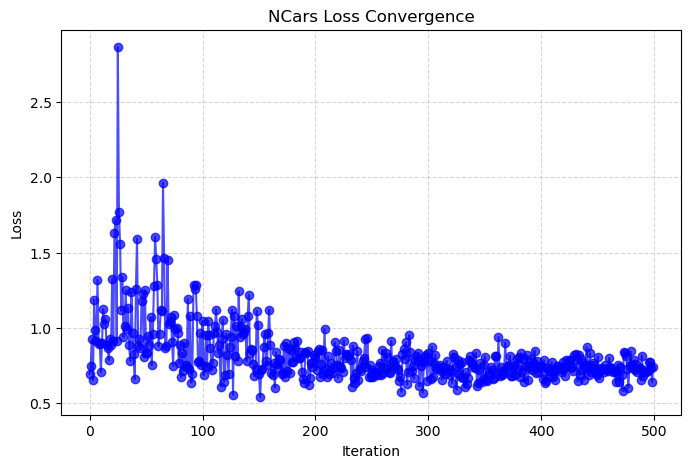

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_convergence(loss_list, title=f"NCars Loss Convergence", xlabel="Iteration", ylabel="Loss"):
    """
    Plots the loss over iterations to visualize convergence.

    Parameters:
    - loss_list: List or array of loss values over iterations
    - title: Plot title
    - xlabel: X-axis label
    - ylabel: Y-axis label
    """
    plt.figure(figsize=(8,5))
    plt.plot(loss_list, marker='o', linestyle='-', color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

plot_loss_convergence(losses)